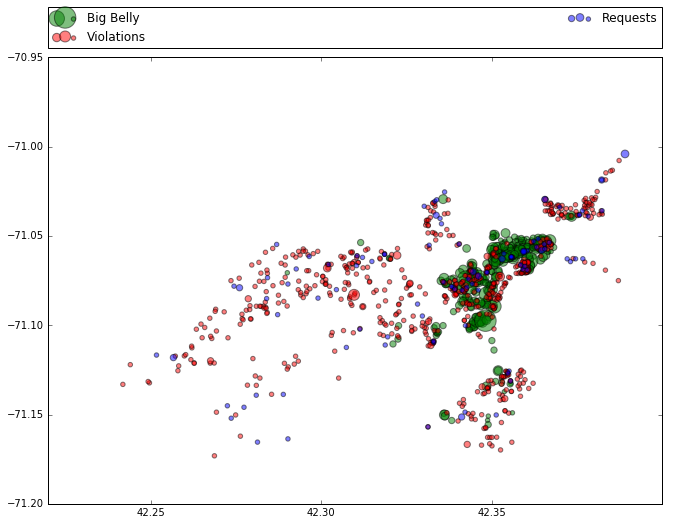

0

In [22]:
%matplotlib inline
import matplotlib.pyplot as plt
import urllib.request
import json
import dml
import prov.model
import datetime
import uuid

# to be used in the scatter plot
COLORMAP = {'Big Belly': 'g', 'Violations': 'r', 'Requests': 'b'}

def project(R, p, dataType):
    return [p(t, dataType) for t in R]

# used to format the data to prepare to graph
def process(R, dataType):
    color = COLORMAP[dataType]
    X = []
    Y = []
    W = []
    for t in R:
        lat = float(t['location'][0])
        lon = float(t['location'][1])
        weight = int(t['count'])
        X.append(lat)
        Y.append(lon)
        W.append(20 * weight)
    plt.scatter(X, Y, s=W, c=color, alpha=0.5, label=dataType)

class optimization(dml.Algorithm):
    contributor = 'andradej_chojoe'
    reads = ['andradej_chojoe.trashSch_transf', \
             'andradej_chojoe.bigbelly_transf', \
             'andrade_chojoe.codeViolations', \
             'andradej_chojoe.hotline_transf']
    writes = ['andradej_chojoe.optimization_results']
    
    
    @staticmethod
    def execute(trial = False):
        startTime = datetime.datetime.now()

        #Set up database connection
        client = dml.pymongo.MongoClient()
        repo = client.repo
        repo.authenticate('andradej_chojoe', 'andradej_chojoe')
        
        repo.dropPermanent('andradej_chojoe.optimization_results')
        repo.createPermanent('andradej_chojoe.optimization_results')
        
        # gather all the datasets
        trashSchData = repo['andradej_chojoe.trashSch_transf'].find()
        bigBellyData = repo['andradej_chojoe.bigbelly_transf'].find()
        codeViolData = repo['andradej_chojoe.codeViol_transf'].find()
        hotlineData = repo['andradej_chojoe.hotline_transf'].find()
        
        # define the figure
        fig = plt.figure(figsize=(11,8))
        
        bigBellyData = process(bigBellyData, 'Big Belly')
        codeViolData = process(codeViolData, 'Violations')
        hotlineData = process(hotlineData, 'Requests')
        #print(codeViolData)
        plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
        plt.show()
        
        return 0
    
    @staticmethod
    def provenance(doc = prov.model.ProvDocument(), startTime = None, endTime = None):
        return 0
    
optimization.execute()
# doc = codeViolations.provenance()
# print(doc.get_provn())
# print(json.dumps(json.loads(doc.serialize()), indent=4))

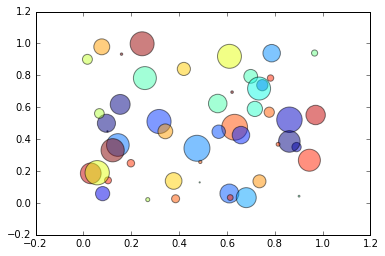

In [11]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt


N = 50
x = np.random.rand(N)
y = np.random.rand(N)
colors = np.random.rand(N)
area = np.pi * (15 * np.random.rand(N))**2  # 0 to 15 point radiuses

plt.scatter(x, y, s=area, c=colors, alpha=0.5)
plt.show()